In [1]:
# enter at Close < ema100, Close < bb_l * 0.985, vol < rolling average x 20
# exit at bb_m
# stop loss -0.05
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)


In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import pandas_ta as p_ta
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
dataframes = {}
def create_raw(symbol, interval_arr, start_time, end_time, step):
    
    url = "https://api.binance.com/api/v3/klines"
    
    for interval in interval_arr:

        raw_df = pd.DataFrame()
        
        for timestamp in range(start_time, end_time, step):
            params = {"symbol": symbol_C,
                      "interval": interval,
                      "startTime": timestamp,
                      "endTime": timestamp + step}
            response = requests.get(url, params=params).json()
            out = pd.DataFrame(response, columns = ["Open_Time", "Open", "High", "Low", "Close",
                                                   "Volume", "Close_Time", "Quote asset volume",
                                                   "Number of trades", "Taker buy base asset volume",
                                                   "Taker buy quote asset volume", "Ignore"])
            raw_df = pd.concat([raw_df, out], axis = 0)

        raw_df = raw_df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']]
        dataframes[f'df_{interval}'] = raw_df

In [5]:
interval_arr = ['5m']
start_time_arr = [1672564611000]
ema_arr = [100]

In [6]:
timezone = 8
symbol = 'maticusdt'
symbol_C = symbol.upper()
interval = '5m'

start_time = 1672564611000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds
step = 60000 * 360

In [7]:
loop_start_time = time.time()
create_raw(symbol, interval_arr, min(start_time_arr), end_time, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
# print(dataframes)

Time taken to execute for loop: 87.17383813858032 seconds


In [8]:
# create_raw(symbol, interval_arr, min(start_time_arr), end_time, step)

# sample = dataframes[f'df_{interval_arr[0]}']
# sample = sample[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)

# sample['Open_Time'] = pd.to_datetime(sample['Open_Time'], unit='ms') + pd.Timedelta(hours=timezone)
# sample['Open_Time'] = sample['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
# print(sample)

In [9]:
def get_klines(symbol, interval, start_time, end_time):
    global dataframes
    df = dataframes[f'df_{interval}']
    df = df[['Open_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)
    df = df.set_index('Open_Time')
#     df = df.reset_index(drop=True)

    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [10]:
def time_format(timezone):
#     df['Open_Time'] = pd.to_datetime(df['Open_Time'], unit='ms') + pd.Timedelta(hours=timezone)
#     df['Open_Time'] = df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
bb_int = 30
bb_dev = 2
rsi_int = 18

In [12]:
df = get_klines(symbol, interval_arr[0], start_time, end_time)
df = df.astype(float).round(4)

# for interval in interval_arr:
#     raw_df = get_klines(symbol, interval, start_time, end_time)
    
#     # ema
#     for ema in ema_arr:
#         column_name = f'ema_{ema}_{interval}'
#         df[column_name] = ta.trend.ema_indicator(raw_df.Close, window=ema)
    
#     # bb
#     bb = ta.volatility.BollingerBands(raw_df.Close, window=bb_int, window_dev=bb_dev)
#     df[f'bb_u_{interval}'] = bb.bollinger_hband()
#     df[f'bb_m_{interval}'] = bb.bollinger_mavg()
#     df[f'bb_l_{interval}'] = bb.bollinger_lband()        

    # rsi
#     rsi = ta.momentum.RSIIndicator(raw_df.Close, window = rsi_int)
#     df[f'rsi_{interval}'] = rsi.rsi()
    
    # atr
#     df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# reset index and set current index as a column
df = df.reset_index()

# set new index with integers
df = df.set_index(pd.RangeIndex(len(df)))

# time_format(timezone)
df['Open_Time'] = df['Open_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

print(df.tail(5))

                 Open_Time    Open   Close    High     Low   Volume
42066  2023-05-27 20:10:00  0.9176  0.9178  0.9183  0.9176  34791.8
42067  2023-05-27 20:15:00  0.9179  0.9179  0.9182  0.9177  43169.1
42068  2023-05-27 20:20:00  0.9179  0.9194  0.9196  0.9179  63846.8
42069  2023-05-27 20:25:00  0.9194  0.9199  0.9203  0.9191  94479.7
42070  2023-05-27 20:30:00  0.9198  0.9202  0.9208  0.9193  93767.6


In [13]:
rsi_up = 74
rsi_low = 35
kd_dir = 'Up'

In [14]:
# def check_cross(df, kd_dir):
#     up = df['slow_k'] > df['slow_d']
#     down = df['slow_k'] < df['slow_d']
#     if kd_dir == 'Up':
#         return up.diff() & up
#     if kd_dir == 'Any':
#         return up.diff()
#     if kd_dir == 'Down':
#         return down.diff() & down


def indicators(df):

# ema
    for i in (ema_arr):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()        
        
# # atr
#     df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# # rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
#     kd_int = 14
#     d_int = 3
   
#     kd_df = pd.DataFrame()
#     kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
#     kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
#     df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
#     df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
#     df['kd_cross'] = check_cross(df, kd_dir)

In [15]:
# indicators(df, kd_dir)
indicators(df)

In [16]:
# df = df.replace('', np.nan)
# df['ema_8_4h'] = df['ema_8_4h'].interpolate()
# df['ema_18_4h'] = df['ema_18_4h'].interpolate()
# df['ema_38_4h'] = df['ema_38_4h'].interpolate()
# df['rsi_1h'] = df['rsi_1h'].interpolate()

In [17]:
def conditions(df):
    for index, row in df.iterrows():
        df['c1'] = df['Close'] < df['ema_100']
        df['c2'] = df['Close'] < (0.985 * df['bb_l'])
        df['c3'] = df['Volume'] < (df['Volume'].rolling(window=30).mean().shift(1) * 20)


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3, 'signal'] = True

#     print(df)

    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
            
    return df

In [18]:
conditions(df)

,Open_Time,Open,Close,High,Low,Volume,ema_100,bb_u,bb_m,bb_l,c1,c2,c3,signal,openbuy
0,2023-01-01 17:20:00,0.7535,0.7544,0.7545,0.7535,24727.4,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 17:25:00,0.7545,0.7541,0.7551,0.7540,68079.8,NaN,NaN,NaN,NaN,False,False,False,False,False
2,2023-01-01 17:30:00,0.7542,0.7551,0.7551,0.7542,25993.6,NaN,NaN,NaN,NaN,False,False,False,False,False
3,2023-01-01 17:35:00,0.7550,0.7552,0.7555,0.7549,25063.6,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2023-01-01 17:40:00,0.7551,0.7559,0.7559,0.7548,40691.0,NaN,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42066,2023-05-27 20:10:00,0.9176,0.9178,0.9183,0.9176,34791.8,0.917870,0.921321,0.918553,0.915786,True,False,True,False,False
42067,2023-05-27 20:15:00,0.9179,0.9179,0.9182,0.9177,43169.1,0.917871,0.920983,0.918433,0.915884,False,False,True,False,False
42068,2023-05-27 20:20:00,0.9179,0.9194,0.9196,0.9179,63846.8,0.917901,0.920585,0.918350,0.916115,False,False,True,False,False
42069,2023-05-27 20:25:00,0.9194,0.9199,0.9203,0.9191,94479.7,0.917941,0.920497,0.918330,0.916163,False,False,True,False,False


In [19]:
# sl_atr = 3
# tp_atr = 5

In [20]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
# atr_val = entry_df[f'atr_{interval_arr[0]}']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] * 0.997 # - sl_atr * atr_val.shift(1).at[index]
#         entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] * 1.0025 # + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
#         take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= entry_df.at[index, 'bb_m']):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
#         take_profit = np.nan
        entry_df.at[index, 'take_profit'] = close_val.at[index]
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                 Open_Time    Open   Close    High     Low     Volume  \
4305   2023-01-16 16:05:00  1.0142  0.9692  1.0145  0.9690  3340624.8   
4306   2023-01-16 16:10:00  0.9694  0.9867  0.9892  0.9666  3085747.1   
4328   2023-01-16 18:00:00  0.9919  0.9947  0.9950  0.9915   165281.6   
4974   2023-01-18 23:50:00  0.9921  0.9601  0.9921  0.9601  4182748.8   
4975   2023-01-18 23:55:00  0.9602  0.9758  0.9785  0.9569  2432740.7   
4980   2023-01-19 00:20:00  0.9609  0.9438  0.9616  0.9250  6527516.1   
6781   2023-01-25 06:25:00  0.9795  0.9486  0.9795  0.9401  4285932.6   
6782   2023-01-25 06:30:00  0.9492  0.9589  0.9612  0.9475  1159662.4   
6804   2023-01-25 08:20:00  0.9464  0.9456  0.9475  0.9400  1163234.1   
11394  2023-02-10 06:50:00  1.2247  1.2068  1.2249  1.2015  1857132.8   
11395  2023-02-10 06:55:00  1.2066  1.2200  1.2240  1.2058  2019107.3   
11413  2023-02-10 08:25:00  1.2343  1.2396  1.2414  1.2321   735670.0   
14302  2023-02-20 09:10:00  1.4657  1.4354  1.4657 

In [21]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Open_Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'ema_100', 'bb_l', 'bb_m', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[index, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit   Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0    0.11  0.03        0.05     -0.04          4          4.61   24.56%   

  Win_Rate  
0   60.00%  

              Open_Time    Open   Close    High     Low     Volume   ema_100  \
0   2023-01-16 16:10:00  0.9694  0.9867  0.9892  0.9666  3085747.1  1.012427   
1   2023-01-16 18:00:00  0.9919  0.9947  0.9950  0.9915   165281.6  1.004470   
2   2023-01-18 23:55:00  0.9602  0.9758  0.9785  0.9569  2432740.7  0.999870   
3   2023-01-19 00:20:00  0.9609  0.9438  0.9616  0.9250  6527516.1  0.996118   
4   2023-01-25 06:30:00  0.9492  0.9589  0.9612  0.9475  1159662.4  0.997645   
5   2023-01-25 08:20:00  0.9464  0.9456  0.9475  0.9400  1163234.1  0.982513   
6   2023-02-10 06:55:00  1.2066  1.2200  1.2240  1.2058  2019107.3  1.280064   
7   2023-02-10 08:25:00  1.2343  1.2396  1.2414  1.2321   735670.0  1.265364   
8   2023-02-20 09:15:00  1.4354  1.4440  1.4452  1.4311  3088906.5  1.489683   
9   2023-02-20 10:35:0

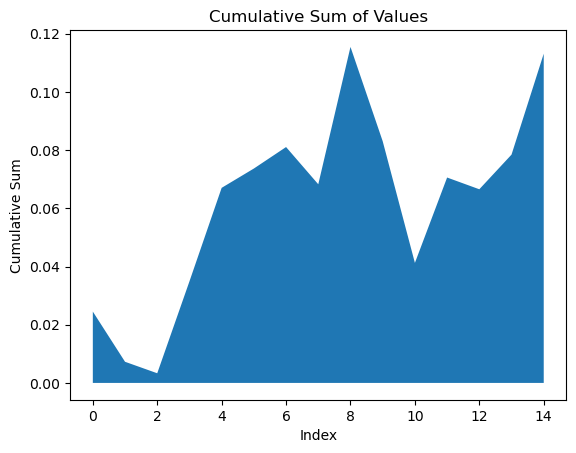

[0.024518050000000124, 0.0072661000000001745, 0.0033190000000001205, 0.034895800000000116, 0.0670436000000001, 0.07367715000000007, 0.08106475000000037, 0.06826555000000023, 0.11547420000000042, 0.08306085000000031, 0.04125060000000032, 0.07058685000000031, 0.06655260000000038, 0.07845980000000036, 0.11314540000000031]


In [22]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

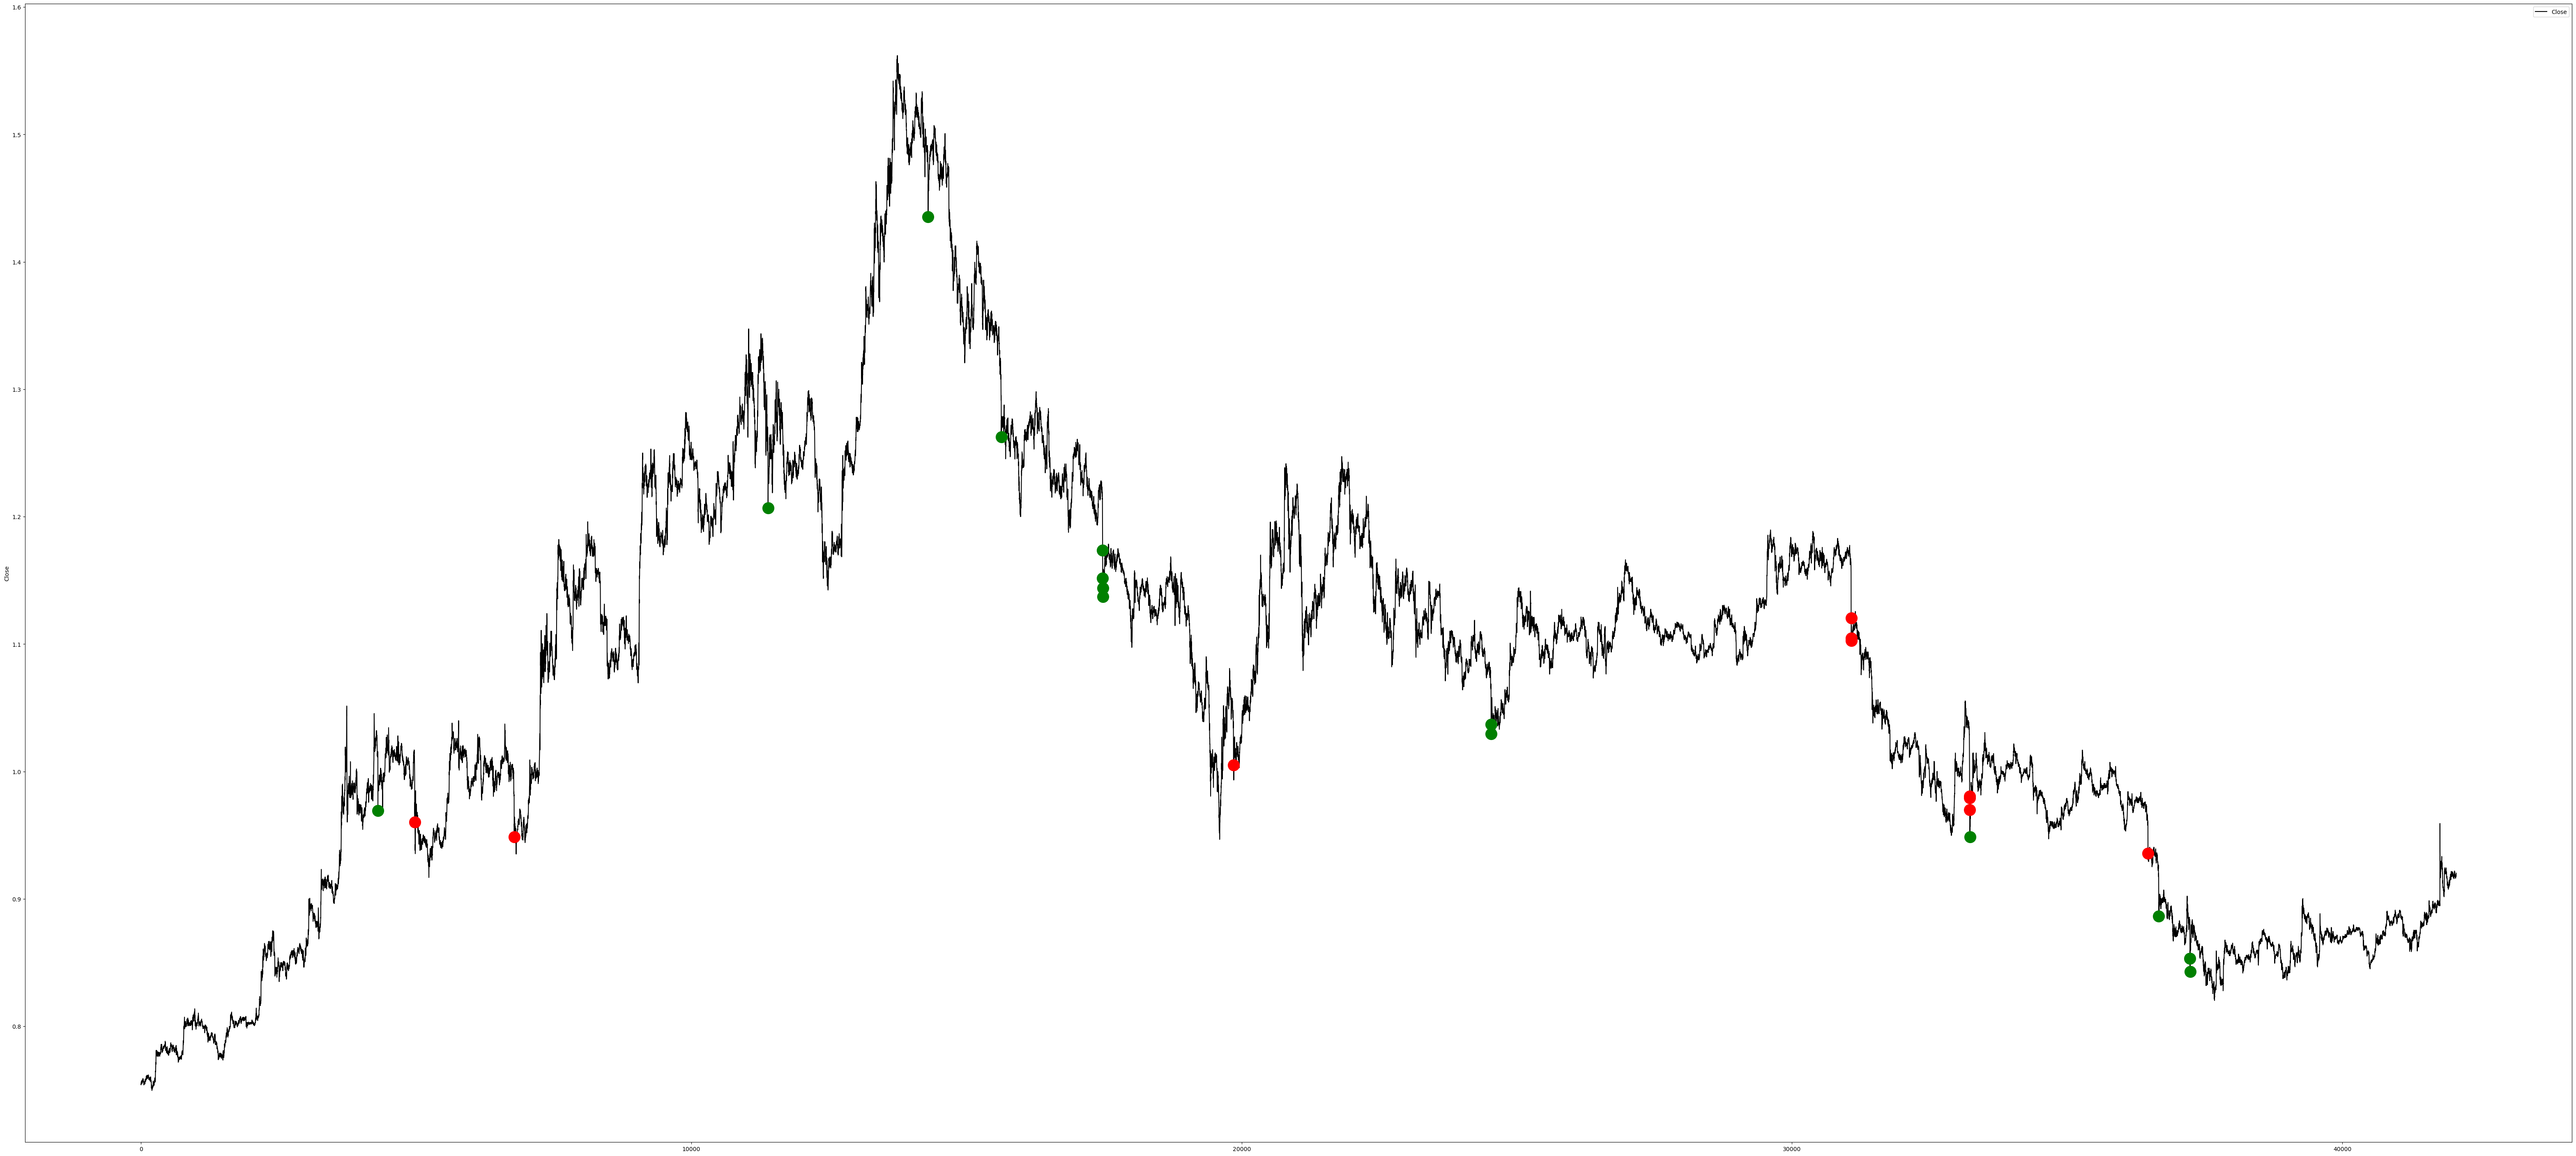

In [23]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位